# MODELING COVID 19

# Content
- Modeling COVID 19
    - Overview
    - The SIR Model
    - Implementation
    - Experiments
    - Ending Lockdown

## Overview
The purpose of this notebook is to introduce economists to quantitative modeling of infectious disease dynamics. Dynamics are modeled using a standard **SIR** (Susceptible-Infected-Removed) model of disease spread, see [compartmental models in epidemiology](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology). The model dynamics are represented by a system of ordinary differential equations. The main objective is to study the impact of suppression through social distancing on the spread of the infection. The focus is on US outcomes but the parameters can be adjusted to study other countries. We will use the following standard imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import exp
from scipy.integrate import odeint # SciPy’s numerical routine odeint for solving differential equations.

plt.rcParams["figure.figsize"] = (11, 5)  # set default figure size

## The SIR Model

All individuals in the population are assumed to be in one of these four states. 

The states are: susceptible (S), exposed (E), infected (I) and removed (R).

Comments:
- Those in state R have been infected and either recovered or died.
- Those who have recovered are assumed to have acquired immunity.
- Those in the exposed group are not yet infectious

### Time Path

The flow across states follows the path $S\rightarrow E\rightarrow I\rightarrow R$. All individuals in the population are eventually infected when the transmission rate, $\beta(t)$ is positive and the number of infected individuals is positive, $i(0)>0$.

The interest is primarily in
- the number of infections at a given time (which determines whether or not the health care system is overwhelmed)
- how long the caseload can be deferred (hopefully until a vaccine arrives)

Using lower case letters for the fraction of the population in each state, the dynamics are


<a id='equation-sir-system'></a>
$$
\begin{aligned}
\dot s(t) = -\beta(t)s(t)i(t) \\
\dot e(t) = \beta(t)s(t)i(t)-\sigma e(t) \\
\dot i(t) = \sigma e(t) - \gamma i(t)
\end{aligned}\tag{1.1}
$$


In these equations,
- $\beta(t)$ is called the *transmission rate* (the rate at which individuals bump into others and expose them to the virus).
- $\sigma$ is called the *infection rate* (the rate at which those who are exposed become infected)
- $\lambda$ is called the *recovery rate* (the rate at which infected people recover or die).
- the dot symbol $\dot y$ represents the time derivative $\frac{dy}{dt}$.

We do not need to model the fraction of the population in state $R$ separately because the states form a partition. In particular, the “removed” fraction of the population is $r=1-s-e-i$

We will also track $c=i+r$, which is the cumulative caseload (i.e., all those who have or have had the infection). The system [(1.1)](#equation-sir-system) can be written in vector form as

<a id='equation-sir-system'></a>
$$
\begin{aligned}
\dot x = F(x,t) \\
x:=(s,e,i)
\end{aligned}\tag{1.2}
$$

### Parameters

Both $\sigma$ and $\gamma$ are thought of as fixed, biologically determined parameters.
we set
- $\sigma = \frac{1}{5.2}$ to reflect an average incubation period of 5.2 days.
- $\gamma = \frac{1}{18}$ to match an average illness duration of 18 days.

The transmission rate is modeled as
- $\beta(t) := R(t)\gamma$ where $R(t)$ is the *effective reproduction number*, or the expected number of new infections caused by an infectious individual in a population where some individuals may no longer be susceptible, at time $t$.

(The notation is slightly confusing, since $R(t)$ is different to $R$, the symbol that represents the removed state.)

## Implementation

In [2]:
# population size of the US
pop_size = 3.3e8 

# fix the parameters as above
gamma = 1 / 18
sigma = 1 / 5.2

In [3]:
def F(x, t, R_zero=1.6):
    """
    Time derivative of the state vector.
        * x is the state vector (array_like)
        * t is time (scalar)
        * R_zero is the effective transmission rate, defaulting to a constant
    """
    s, e, i = x

    # New exposure of susceptibles
    # Note that R_zero can be either constant or a given function of time.
    beta = R_zero(t) * gamma if callable(R_zero) else R_zero * gamma 
    ne = beta * s * i

    # Time derivatives
    ds = - ne
    de = ne - sigma * e
    di = sigma * e - gamma * i

    return ds, de, di

In [4]:
# initial conditions of s, e, i
i_0 = 1e-7
e_0 = 4 * i_0
s_0 = 1 - i_0 - e_0

x_0 = s_0, e_0, i_0

In [5]:
def solve_path(R_zero, t_vec, x_init=x_0):
    """
    Solve for i(t) and c(t) via numerical integration,
    given the time path for R_zero.
    """
    G = lambda x, t: F(x, t, R_zero)
    s_path, e_path, i_path = odeint(G, x_init, t_vec).transpose()

    c_path = 1 - s_path - e_path       # cumulative cases
    return i_path, c_path

## Experiments
Let’s run some experiments using this code. The time period we investigate will be 550 days, or around 18 months:

In [6]:
t_length = 550
grid_size = 1000
t_vec = np.linspace(0, t_length, grid_size)

### Experiment 1: Constant $R_0$ Case

Let’s start with the case where $R_0$ is constant. We calculate the time path of infected people under different assumptions for $R_0$:

In [7]:
R_zero_vals = np.linspace(1.6, 3.0, 6)
labels = [f'$R_0 = {r:.2f}$' for r in R_zero_vals]
i_paths, c_paths = [], []

for r in R_zero_vals:
    i_path, c_path = solve_path(r, t_vec)
    i_paths.append(i_path)
    c_paths.append(c_path)

In [8]:
def plot_paths(paths, labels, times=t_vec):

    _, ax = plt.subplots()

    for path, label in zip(paths, labels):
        ax.plot(times, path, label=label)

    ax.legend(loc='upper left')

    plt.show()

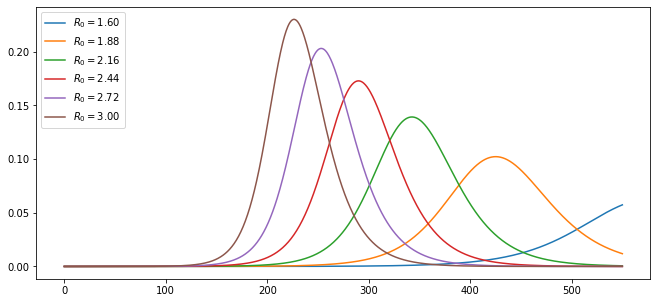

In [9]:
plot_paths(i_paths, labels)

As expected, lower effective transmission rates defer the peak of infections. They also lead to a lower peak in current cases. Here are cumulative cases, as a fraction of population:

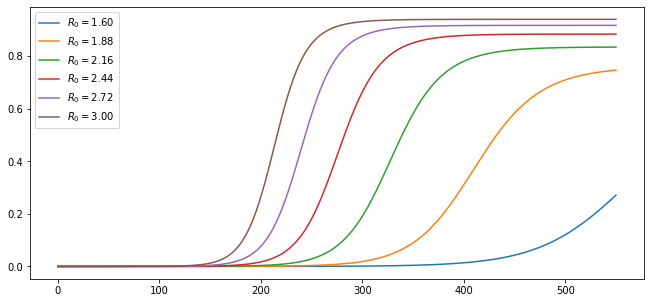

In [10]:
plot_paths(c_paths, labels)

## Experiment 2: Changing Mitigation

Let’s look at a scenario where mitigation (e.g., social distancing) is successively imposed.

Here’s a specification for $R_0$ as a function of time.

In [11]:
def R_zero_mitigating(t, R_zero=3, eta=1, r_bar=1.6):
    R_zero = R_zero * exp(- eta * t) + (1 - exp(- eta * t)) * r_bar
    return R_zero

The idea is that $R_0$ starts off at 3 and falls to 1.6. This is due to progressive adoption of stricter mitigation measures. The parameter $\eta$ controls the rate, or the speed at which restrictions are imposed. We consider several different rates:


In [12]:
eta_vals = 1/5, 1/10, 1/20, 1/50, 1/100
labels = [fr'$\eta = {eta:.2f}$' for eta in eta_vals]

This is what the time path of $R_0$ looks like at these alternative rates:

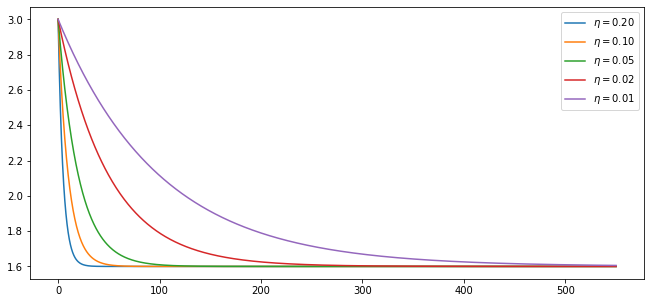

In [13]:
fig, ax = plt.subplots()

for eta, label in zip(eta_vals, labels):
    ax.plot(t_vec, R_zero_mitigating(t_vec, eta=eta), label=label)

ax.legend()
plt.show()

Let’s calculate the time path of infected people:

In [14]:
i_paths, c_paths = [], []

for eta in eta_vals:
    R_zero = lambda t: R_zero_mitigating(t, eta=eta)
    i_path, c_path = solve_path(R_zero, t_vec)
    i_paths.append(i_path)
    c_paths.append(c_path)

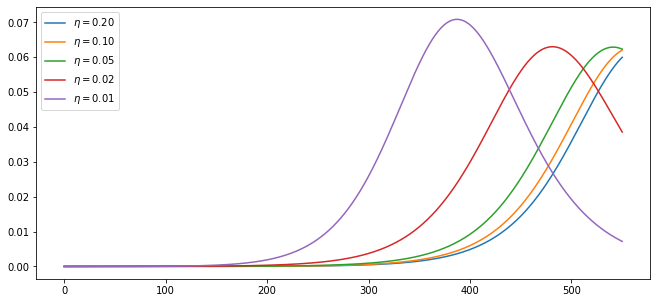

In [15]:
plot_paths(i_paths, labels)


Here are cumulative cases, as a fraction of population:

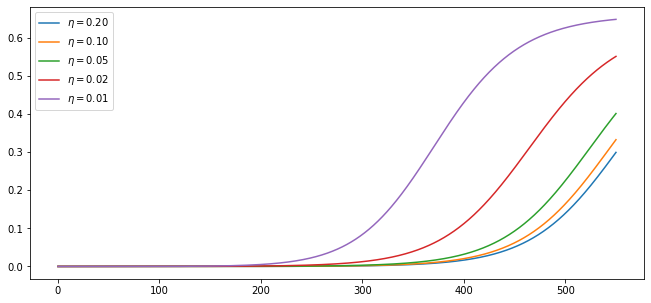

In [16]:
plot_paths(c_paths, labels)

## Ending Lockdown
The following replicates [additional results](https://drive.google.com/file/d/1uS7n-7zq5gfSgrL3S0HByExmpq4Bn3oh/view) by Andrew Atkeson on the timing of lifting lockdown.

Consider these two mitigation scenarios:
1. $R_t = .5$ for 30 days then $R_t = 2$  for the remaining 17 months. This corresponds to lifting lockdown in 30 days.
2. $R_t = .5$ for 120 days then $R_t = 2$  for the remaining 14 months. This corresponds to lifting lockdown in 4 months.

The parameters considered here start the model with 25,000 active infections and 75,000 agents already exposed to the virus and thus soon to be contagious.

In [17]:
# initial conditions
i_0 = 25_000 / pop_size
e_0 = 75_000 / pop_size
s_0 = 1 - i_0 - e_0
x_0 = s_0, e_0, i_0

In [18]:
R_zero_paths = (lambda t: 0.5 if t < 30 else 2,
            lambda t: 0.5 if t < 120 else 2)

labels = [f'scenario {i}' for i in (1, 2)]

i_paths, c_paths = [], []

for R_zero in R_zero_paths:
    i_path, c_path = solve_path(R_zero, t_vec, x_init=x_0)
    i_paths.append(i_path)
    c_paths.append(c_path)

Here is the number of active infections:

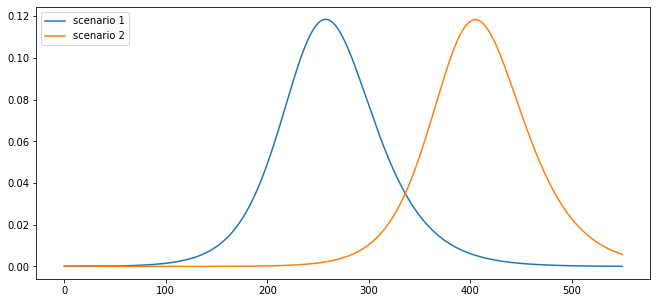

In [19]:
plot_paths(i_paths, labels)

What kind of mortality can we expect under these scenarios? Suppose that 1% of cases result in death

In [20]:
nu = 0.01

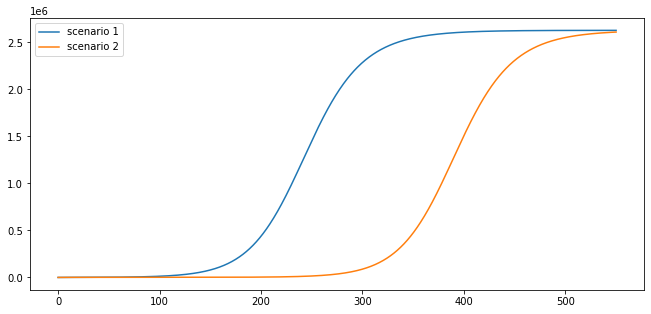

In [21]:
paths = [path * nu * pop_size for path in c_paths]
plot_paths(paths, labels)

This is the daily death rate:

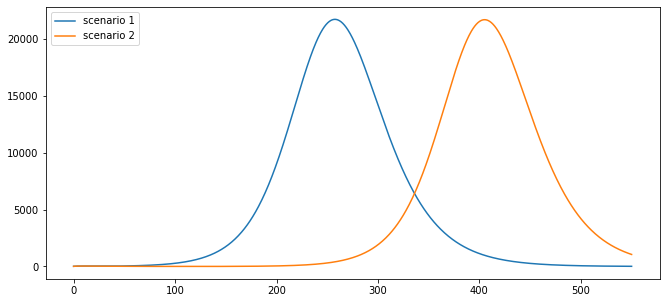

In [22]:
paths = [path * nu * gamma * pop_size for path in i_paths]
plot_paths(paths, labels)

Pushing the peak of curve further into the future may reduce cumulative deaths if a vaccine is found.